In [2]:

import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
# import seaborn as sns
import torch
from tqdm.notebook import tqdm
# from utils import latexify

torch.set_default_tensor_type(torch.DoubleTensor)

/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [3]:
# latexify(6, 4)

In [4]:
ETFS = ['AGG', 'VTI', 'VNQ', 'XLF', 'XLV', 'XLY', 'XLP', 'XLU', 'XLI', 'XLE', 'IBB', 'ITA']

In [5]:
N_ASSETS = len(ETFS)
HZN = 24
VAL = 2443
TEST = 0
KAPPA = np.full(N_ASSETS, 0.001)
SHORT = np.full(N_ASSETS, 0.001)
GAMMA = 12.0

M1 = torch.tensor(2.0)
M2 = torch.tensor(1.00)
len(ETFS)

12

In [6]:
MU = np.load('data/markowitz_mu.npy')
COV = np.load('data/markowitz_sigma.npy')
COV_SQRT = scipy.linalg.sqrtm(COV)

mulog = torch.tensor(np.load('data/markowitz_mu_log.npy'))
covlog = torch.tensor(np.load('data/markowitz_cov_log.npy'))

In [24]:
logreturn1p_dist = torch.distributions.MultivariateNormal(
    mulog, covlog)


In [27]:
ret = np.exp(logreturn1p_dist.sample((3000,))).numpy()

In [28]:
ret.shape

(3000, 12)

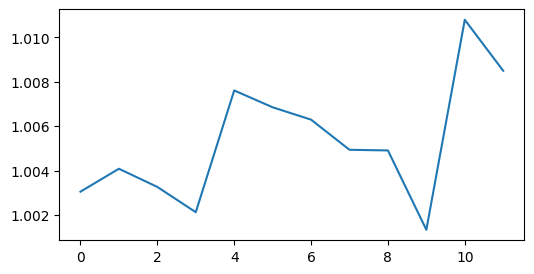

In [ ]:
plt.figure(figsize=(6,3))
plt.plot([np.mean(ret[:,s]) for s in range(12)])


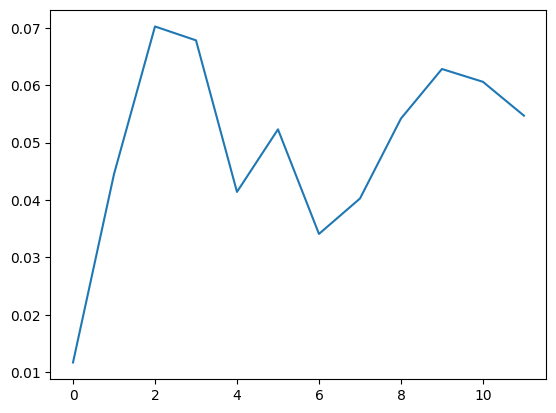

In [31]:
plt.plot([np.std(ret[:,s]) for s in range(12)])

(array([ 24., 122., 325., 592., 719., 631., 360., 155.,  56.,  16.]),
 array([0.85791823, 0.89000684, 0.92209545, 0.95418407, 0.98627268,
        1.0183613 , 1.05044991, 1.08253852, 1.11462714, 1.14671575,
        1.17880436]),
 <BarContainer object of 10 artists>)

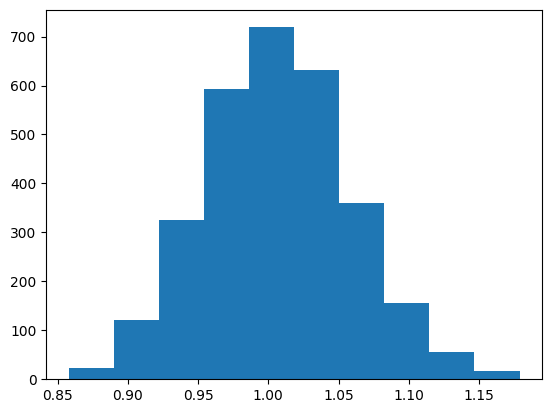

In [36]:
plt.hist(ret[:,5])

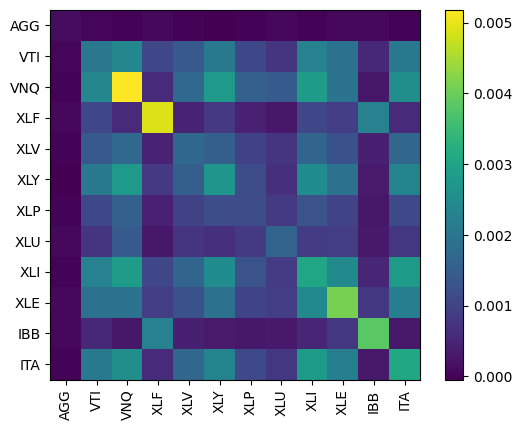

In [78]:
plt.imshow(COV)
plt.colorbar()
plt.xticks(np.arange(N_ASSETS), ETFS, rotation=90)
plt.yticks(np.arange(N_ASSETS), ETFS)
plt.show()

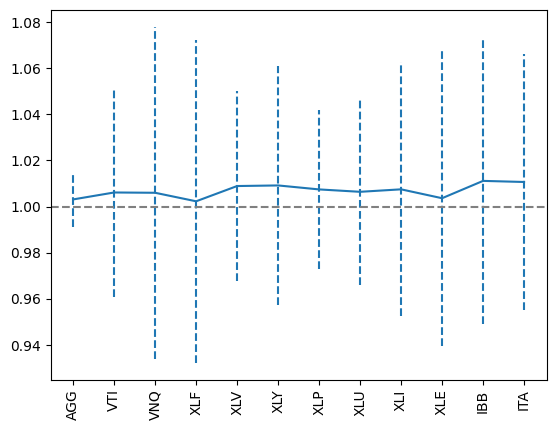

In [79]:
def plot_mean_std(mu, cov):
    ax = plt.gca()
    eb = plt.errorbar(np.arange(N_ASSETS), mu, yerr=np.sqrt(np.diag(cov)))
    eb[-1][0].set_linestyle('--')
    ax.axhline(1.0, linestyle='--', color='gray')
    plt.xticks(np.arange(N_ASSETS), ETFS, rotation=90)
    
plot_mean_std(MU, COV)
plt.show()

In [80]:
kappa_tch = torch.from_numpy(KAPPA)
logreturn1p_dist = torch.distributions.MultivariateNormal(
    mulog, covlog)

def init_holdings(cov_sqrt, mu, gamma):
    N = N_ASSETS
    ht = cp.Variable(N)   
    
                                                                                                                                                        
    risk = gamma * cp.sum_squares(cov_sqrt @ ht)
    returns = mu.T @ ht
    objective = returns - risk - SHORT.T @ cp.neg(ht)
                                                                                
    constraints = [                                                             
        cp.sum(ht) == 1,
    ]                                                                            
    problem = cp.Problem(cp.Maximize(objective), constraints)
    problem.solve()
    return ht.value

def init_state(batch_size, seed=None):
  if seed is not None:
      torch.manual_seed(seed)
  H0 = torch.tensor(init_holdings(COV_SQRT, MU, GAMMA))
  ret = torch.exp(logreturn1p_dist.sample((batch_size,)))
  newH = ret*H0
  means = torch.sum(newH,axis=1).view((batch_size,1))
  newH = newH/means
  return newH

H0 = init_state(1,seed=TEST)



def utility_fn(x, m1=M1, m2=M2):
    return (x - 1)                                                  


def stage_cost(r):                                                       
    return -utility_fn(r)


def simulate(ht, ut):
    batch_size = ht.shape[0]
    ret = torch.exp(logreturn1p_dist.sample((batch_size,)))
    newx = ret * (ht + ut)
    xsums = torch.sum(newx,axis=1).view((batch_size,1))
    newxnorm = newx/xsums
    return newxnorm, xsums 


def rollout(policy, h0=H0, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    ht = h0                                                                    
    h_seq = [ht]                                                               
    u_seq = []    
    rets = []
    cost = 0.0
    for t in range(HZN):                                                    
        ut = policy(ht)
        ht, htsum = simulate(ht, ut)
        cost += stage_cost(htsum).mean()
        h_seq.append(ht)                                                        
        u_seq.append(ut)
        rets.append(htsum)
    cost = cost / HZN
    # print(cost)
    return cost, h_seq, u_seq, rets


def monte_carlo(policy, h0=H0, trials=10, seed=None, verbose=True):
    if seed is not None:
        torch.manual_seed(seed)
    results = []
    hN = []
    
    if verbose:
        wrapper = lambda x: tqdm(x)
    else:
        wrapper = lambda x: x
    
    # for i in wrapper(range(trials)):
    cost, h_seq, _, rets = rollout(policy, h0)
    results.append(cost)
    hN.append(h_seq[-1])
    return torch.stack(results), hN, rets

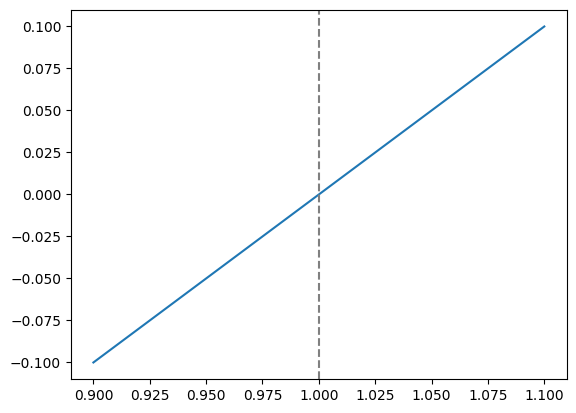

In [81]:
ax = plt.gca()
plt.plot(np.linspace(0.9, 1.1, 1000), [utility_fn(x) for x in np.linspace(.9, 1.1, 1000)])
ax.axvline(1, color='gray', linestyle='--')
plt.show()

In [82]:
def plot_states(policy, ax=None, h0=H0, seed=TEST, style={},
                legend=False, ylabel=True, xlabel=True):
    if ax is None:
        ax = plt.gca()
    colors = sns.color_palette("hls", N_ASSETS)
    _, states, _, _ = rollout(policy, h0=h0, seed=seed)
    # normalized = [s / s.sum() for s in states]
    states_stacked = torch.stack(states)
    states_np = states_stacked.detach().numpy()
    for i, etf in enumerate(ETFS):
        holdings = states_np[:,:,i]
        if etf in style:
            ax.plot(holdings, label=etf, linestyle=style[etf], color=colors[i])
        else:
            ax.plot(holdings, label=etf, color=colors[i])
    if xlabel:
        ax.set_xlabel("month")
    if ylabel:
        ax.set_ylabel("holdings")
    ax.set_xticks(np.arange(HZN, step=4))
    ax.set_xlim((0, HZN))
    ax.set_ylim((-.75, .95))
    if legend:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=6)
    plt.tight_layout()
    
    
def plot_controls(policy, ax=None, h0=H0, seed=TEST, style={},
                  legend=False, ylabel=True, xlabel=True):
    if ax is None:
        ax = plt.gca()
    _, states, controls, _ = rollout(policy, h0=h0, seed=seed)
    colors = sns.color_palette("hls", N_ASSETS)
    # normalized = [c / s.sum() for s, c in zip(states, controls)]
    stacked = torch.stack(controls)
    controls_np = stacked.detach().numpy()
    for i, etf in enumerate(ETFS):
        ctrl = controls_np[:,:, i]
        if etf in style:
            ax.plot(ctrl, label=etf, linestyle=style[etf], color=colors[i])
        else:
            ax.plot(ctrl, label=etf, color=colors[i])
    ax.set_xticks(np.arange(HZN, step=4))
    ax.set_xlim((0, HZN))
    if xlabel:
        ax.set_xlabel('month')
    if ylabel:
        ax.set_ylabel('trades')
    if legend:
        ax.legend()
    plt.tight_layout()

In [83]:
def construct_layer():
    N = N_ASSETS
    ht = cp.Parameter(N)   
    cov_sqrt = cp.Parameter((N, N))
    mu = cp.Parameter(N)
    parameters = [ht, cov_sqrt, mu]                     
                                                                                
    ut = cp.Variable(N)                                                         
    htp = cp.Variable(N)             
                                                                                
    risk = cp.sum_squares(cov_sqrt @ htp)
    returns = mu.T @ htp
    objective = returns - risk
                                                                                
    transaction_cost = KAPPA.T @ cp.abs(ut)
    shorting_cost = SHORT.T @ cp.neg(htp)
    constraints = [                                                             
        cp.sum(ut) + transaction_cost + shorting_cost <= 0,                                   
        htp == ht + ut,
    ]                                                                            
    problem = cp.Problem(cp.Maximize(objective), constraints)
    return CvxpyLayer(problem, parameters, [ut])   

In [84]:
class Tuner(object):                                                       
    def __init__(self, mu=MU, gamma=GAMMA, cov_sqrt=COV_SQRT):            
        self.layer = construct_layer()  
        
        self.gamma_sqrt = torch.tensor(np.sqrt(gamma), requires_grad=True)
        self.cov_sqrt = torch.tensor(cov_sqrt, requires_grad=True)
        self.mu = torch.tensor(mu, requires_grad=True)
        self.variables = [self.gamma_sqrt, self.cov_sqrt, self.mu]
        self.solver_args= {'solve_method': "Clarabel" }      

    def __call__(self, ht):
        # norm_ht = ht / ht.sum()
        norm_ut = self.layer(
            ht, self.gamma_sqrt * self.cov_sqrt, self.mu,
            solver_args=self.solver_args)[0]
        return norm_ut

    def project(self):
        self.gamma_sqrt.data = torch.max(self.gamma_sqrt, torch.tensor(0.0))
        
        
untuned = Tuner(gamma=GAMMA, cov_sqrt=COV_SQRT)

In [85]:
STYLE = {
    'AGG': '--',
    'ITA': ':'
}

In [165]:
MU_INIT = MU
GAMMA_INIT = GAMMA
COV_INIT = COV_SQRT

def train(policy, epochs, batch_size=10, test_size = 15, lr=1e-2, print_every=50):    
    opt = torch.optim.SGD(policy.variables, lr=lr)                             
    print("Training for {} epochs (batch size={}, lr={})".format(epochs, batch_size, lr))
    test_utils = []
    
    with torch.no_grad():
        h0 = init_state(test_size,seed = TEST)
        test_costs, _, _ = monte_carlo(policy, h0=h0, trials=10, seed=TEST, verbose=False)
        test_utils.append(-test_costs.mean())
        print('start: test utility ({})'.format(test_utils[-1]))
        
    for epoch in range(epochs):  
        if (epoch + 1) % 20 == 0:
            lr = lr * 0.59
            opt = torch.optim.SGD(policy.variables, lr=lr)
            
        # with torch.no_grad():
            # h0 = init_holdings(policy.cov_sqrt.detach().numpy(), policy.mu.detach().numpy(),
            #                    policy.gamma_sqrt.detach().item()**2)
            

        opt.zero_grad()
        h0 = init_state(batch_size,seed = epoch + 1)
        costs, _, _ = monte_carlo(policy, h0=h0, trials=batch_size, seed=epoch+1, verbose=False)
        costs.mean().backward()
        # print('epoch {}: train utility ({})'.format(
        #             epoch, -costs.mean()))
        
        with torch.no_grad():
            if epoch % print_every == 0:
                h0 = init_state(test_size,seed = TEST)
                test_costs, _, _ = monte_carlo(policy, h0=h0, trials=test_size, seed=TEST, verbose=False)
                test_utils.append(-test_costs.mean())
                print('epoch {}: train utility ({}) test utility ({})'.format(
                    epoch, -costs.mean(), test_utils[-1]))
            # if epoch % 40 == 0:
            #     print(policy.cov_sqrt.detach().numpy(),policy.mu.detach().numpy(), policy.gamma_sqrt.detach().item()**2)
                # print('\tmu.grad.norm ', policy.mu.grad.norm().item())
                # print('\tgamma.grad.norm ', policy.gamma_sqrt.grad.norm().item())
                # print('\tcov_sqrt.grad.norm ', policy.cov_sqrt.grad.norm().item())
                # print('\tgamma ', policy.gamma_sqrt.detach().item()**2)
                # plot_mean_std(policy.mu.detach().numpy(),
                #              (policy.cov_sqrt.T @ policy.cov_sqrt).detach().numpy())
                # plt.show()
                
                # plot_states(policy, h0=h0, seed=TEST, style=STYLE, legend=True)
                # plt.show()
                
                # plot_controls(policy, h0=h0, seed=TEST, style=STYLE)
                # plt.show()
                
        opt.step()
        with torch.no_grad():                                                   
            policy.project()                                                    
            
    return test_utils

In [166]:
TOTAL_SIMS = 10000
BATCH_SIZE = 10
TEST_SIZE = 25
EPOCHS = int(TOTAL_SIMS / BATCH_SIZE)
LR = 1e-3
PRINT_EVERY = 10
MU_INIT = MU
GAMMA_INIT = GAMMA
COV_INIT = COV_SQRT
tuned = Tuner(mu=MU_INIT, gamma=GAMMA_INIT, cov_sqrt=COV_INIT)
test_utils = train(tuned, lr=LR, epochs=EPOCHS, batch_size=BATCH_SIZE, test_size = TEST_SIZE, print_every=PRINT_EVERY)

Training for 1000 epochs (batch size=10, lr=0.001)
start: test utility (0.007156710265615992)
epoch 0: train utility (0.006807310824420404) test utility (0.007156710265615992)
epoch 10: train utility (0.005756695152993776) test utility (0.007522790887762333)
epoch 20: train utility (0.010638436080247393) test utility (0.008845803373325556)
epoch 30: train utility (0.01633860732278507) test utility (0.01533418709250795)
epoch 40: train utility (0.00762455090773519) test utility (0.008377393007318799)
epoch 50: train utility (0.006754404725271595) test utility (0.008681839165691615)
epoch 60: train utility (0.007399047968342604) test utility (0.009063557495989593)
epoch 70: train utility (0.009858042043151409) test utility (0.009322525444411109)
epoch 80: train utility (0.00823881225766881) test utility (0.00956479469629021)
epoch 90: train utility (0.009092613997435718) test utility (0.009713282999489184)
epoch 100: train utility (0.009259185689598373) test utility (0.00988006843280276)

In [167]:
tuned_h0 = init_holdings(tuned.cov_sqrt.detach().numpy(),
                         tuned.mu.detach().numpy(),
                         tuned.gamma_sqrt.detach().item()**2)
tuned_h0 = torch.tensor(tuned_h0).view((1,12))

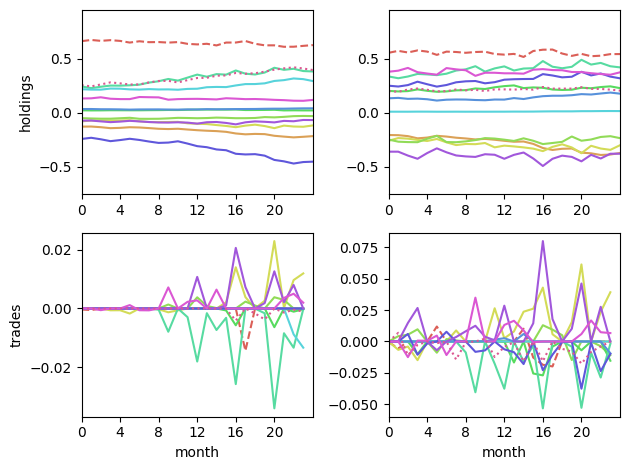

In [168]:
# latexify(fig_width=8.0, fig_height=4.0)
fig, axs = plt.subplots(2, 2)

plot_states(untuned, ax=axs[0][0], h0=H0, seed=TEST, xlabel=False, legend=False, style=STYLE)
plot_states(tuned, ax=axs[0][1], h0=tuned_h0, seed=TEST, ylabel=False, xlabel=False, legend=False, style=STYLE)


plot_controls(untuned, ax=axs[1][0], h0=H0, seed=TEST, style=STYLE)
plot_controls(tuned, ax=axs[1][1], h0=tuned_h0, seed=TEST, ylabel=False,style=STYLE)

# plt.savefig('mark-state-ctrl.pdf')

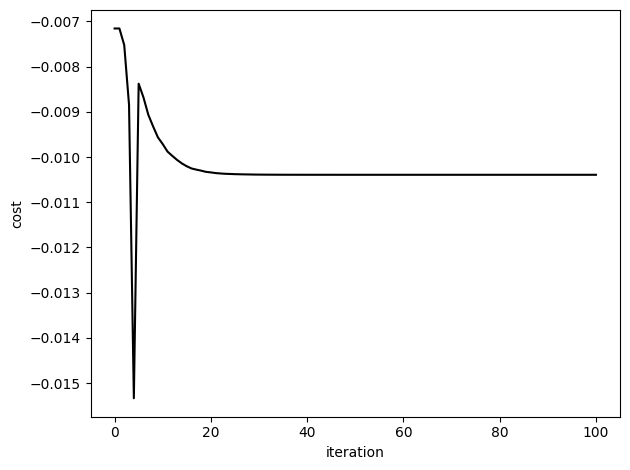

In [169]:
# latexify(fig_width=6.5, fig_height=1.9)

_, ax = plt.subplots(1, 1)
ax.plot([-u for u in test_utils], color='black')
ax.set_ylabel('cost')
ax.set_xlabel('iteration')
# ax.set_ylim([-0.035,-0.0])

# ax.set_yticks([-0.00425, -0.00475, -0.00525])
plt.tight_layout()
# plt.savefig('mark-training.pdf')
# lr 1e-3 10/25 20/0.59

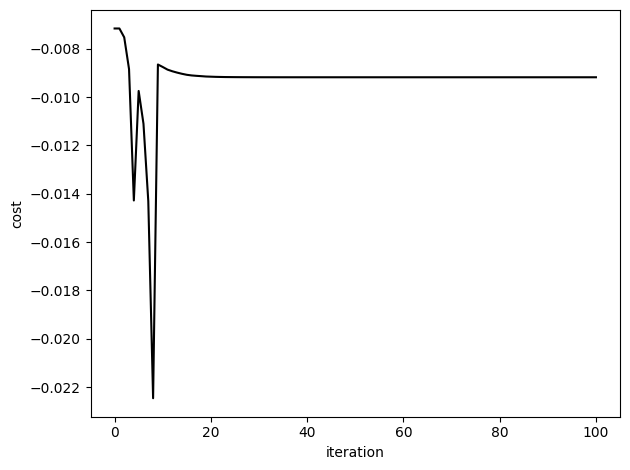

In [162]:
# latexify(fig_width=6.5, fig_height=1.9)

_, ax = plt.subplots(1, 1)
ax.plot([-u for u in test_utils], color='black')
ax.set_ylabel('cost')
ax.set_xlabel('iteration')
# ax.set_ylim([-0.035,-0.0])

# ax.set_yticks([-0.00425, -0.00475, -0.00525])
plt.tight_layout()
# plt.savefig('mark-training.pdf')
# lr 1e-3 10/25 20/0.56

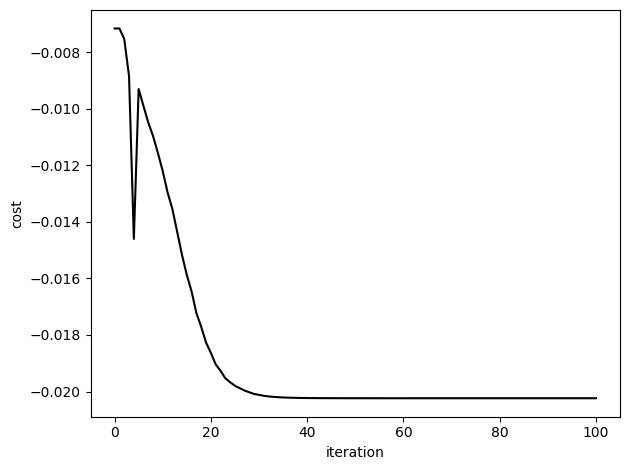

In [157]:
# latexify(fig_width=6.5, fig_height=1.9)

_, ax = plt.subplots(1, 1)
ax.plot([-u for u in test_utils], color='black')
ax.set_ylabel('cost')
ax.set_xlabel('iteration')
# ax.set_ylim([-0.035,-0.0])

# ax.set_yticks([-0.00425, -0.00475, -0.00525])
plt.tight_layout()
# plt.savefig('mark-training.pdf')
# lr 1e-3 10/25 20/0.58

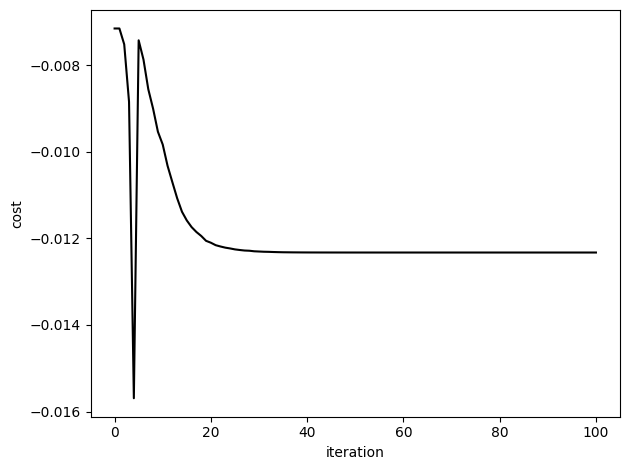

In [152]:
# latexify(fig_width=6.5, fig_height=1.9)

_, ax = plt.subplots(1, 1)
ax.plot([-u for u in test_utils], color='black')
ax.set_ylabel('cost')
ax.set_xlabel('iteration')
# ax.set_ylim([-0.035,-0.0])

# ax.set_yticks([-0.00425, -0.00475, -0.00525])
plt.tight_layout()
# plt.savefig('mark-training.pdf')
# lr 1e-3 10/25 20/0.6

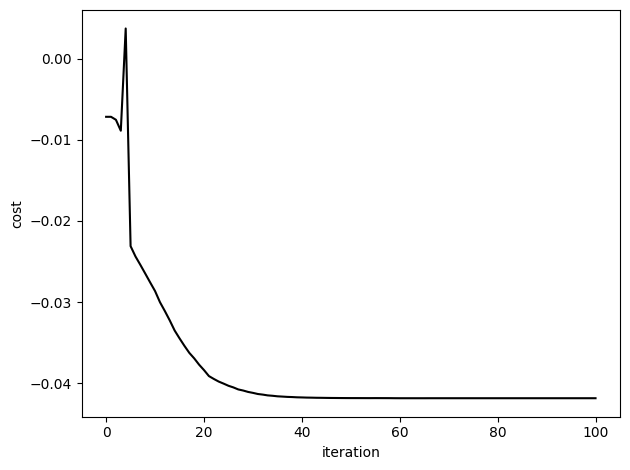

In [137]:
# latexify(fig_width=6.5, fig_height=1.9)

_, ax = plt.subplots(1, 1)
ax.plot([-u for u in test_utils], color='black')
ax.set_ylabel('cost')
ax.set_xlabel('iteration')
# ax.set_ylim([-0.035,-0.0])

# ax.set_yticks([-0.00425, -0.00475, -0.00525])
plt.tight_layout()
# plt.savefig('mark-training.pdf')
# lr 1e-3 10/25 20/0.68

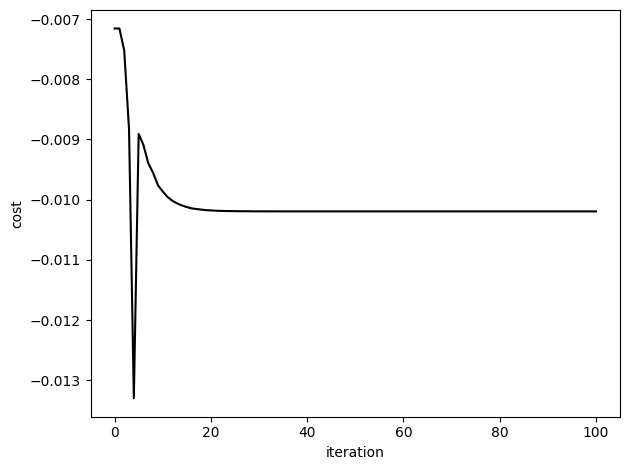

In [132]:
# latexify(fig_width=6.5, fig_height=1.9)

_, ax = plt.subplots(1, 1)
ax.plot([-u for u in test_utils], color='black')
ax.set_ylabel('cost')
ax.set_xlabel('iteration')
# ax.set_ylim([-0.035,-0.0])

# ax.set_yticks([-0.00425, -0.00475, -0.00525])
plt.tight_layout()
# plt.savefig('mark-training.pdf')
# lr 1e-3 10/25 20/0.55

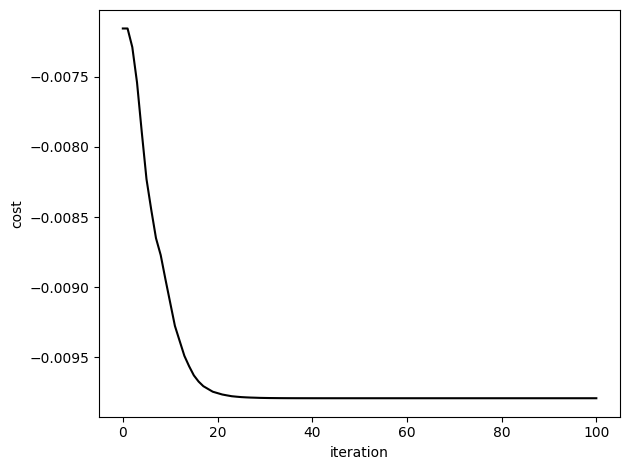

In [128]:
# latexify(fig_width=6.5, fig_height=1.9)

_, ax = plt.subplots(1, 1)
ax.plot([-u for u in test_utils], color='black')
ax.set_ylabel('cost')
ax.set_xlabel('iteration')
# ax.set_ylim([-0.035,-0.0])

# ax.set_yticks([-0.00425, -0.00475, -0.00525])
plt.tight_layout()
# plt.savefig('mark-training.pdf')
# lr 5e-4 10/25 20/0.55

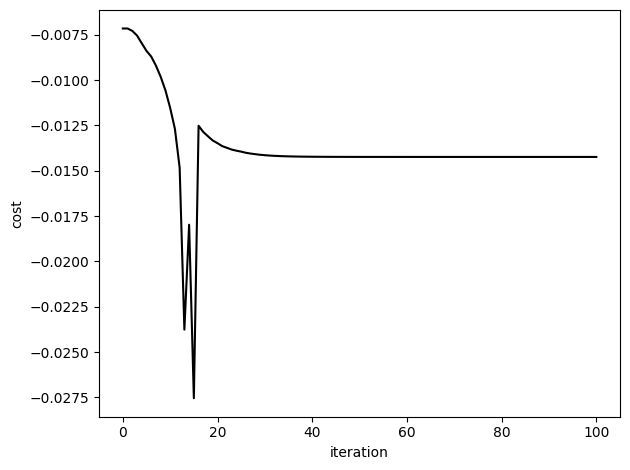

In [ ]:
# latexify(fig_width=6.5, fig_height=1.9)

_, ax = plt.subplots(1, 1)
ax.plot([-u for u in test_utils], color='black')
ax.set_ylabel('cost')
ax.set_xlabel('iteration')
# ax.set_ylim([-0.035,-0.0])

# ax.set_yticks([-0.00425, -0.00475, -0.00525])
plt.tight_layout()
# plt.savefig('mark-training.pdf')
# lr 5e-4 10/25 20/0.65

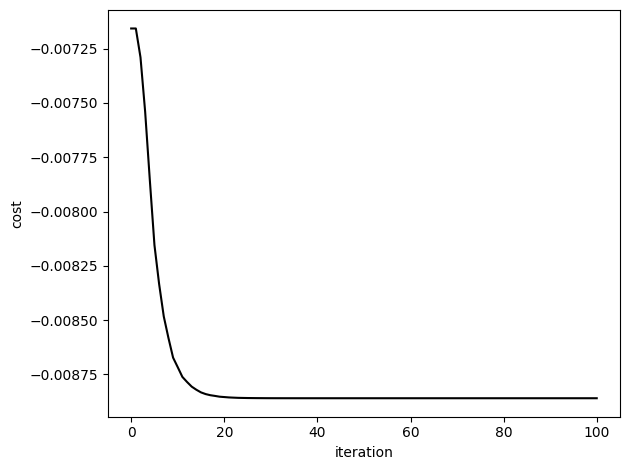

In [113]:
# latexify(fig_width=6.5, fig_height=1.9)

_, ax = plt.subplots(1, 1)
ax.plot([-u for u in test_utils], color='black')
ax.set_ylabel('cost')
ax.set_xlabel('iteration')
# ax.set_ylim([-0.035,-0.0])

# ax.set_yticks([-0.00425, -0.00475, -0.00525])
plt.tight_layout()
# plt.savefig('mark-training.pdf')
# lr 5e-4 10/25 20/0.5

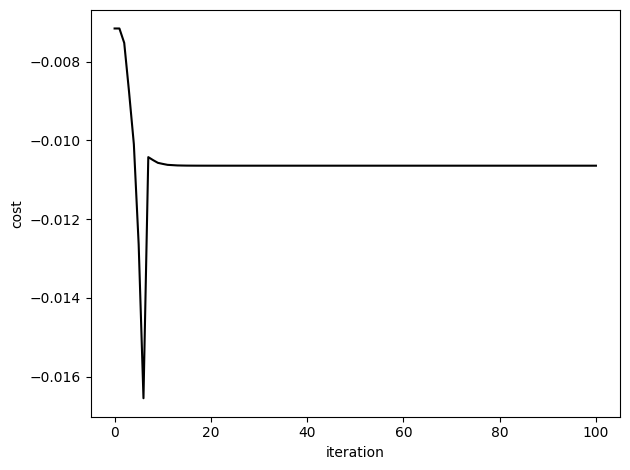

In [107]:
# latexify(fig_width=6.5, fig_height=1.9)

_, ax = plt.subplots(1, 1)
ax.plot([-u for u in test_utils], color='black')
ax.set_ylabel('cost')
ax.set_xlabel('iteration')
# ax.set_ylim([-0.035,-0.0])

# ax.set_yticks([-0.00425, -0.00475, -0.00525])
plt.tight_layout()
# plt.savefig('mark-training.pdf')
# lr 1e-3 10/25 20/0.3

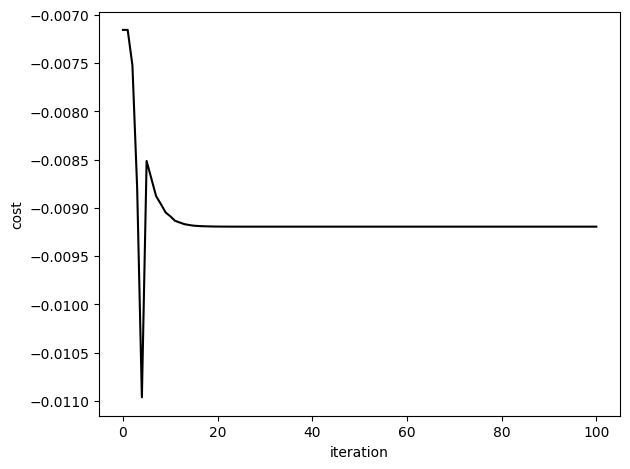

In [102]:
# latexify(fig_width=6.5, fig_height=1.9)

_, ax = plt.subplots(1, 1)
ax.plot([-u for u in test_utils], color='black')
ax.set_ylabel('cost')
ax.set_xlabel('iteration')
# ax.set_ylim([-0.035,-0.0])

# ax.set_yticks([-0.00425, -0.00475, -0.00525])
plt.tight_layout()
# plt.savefig('mark-training.pdf')
# lr 1e-3 10/25 20/0.4

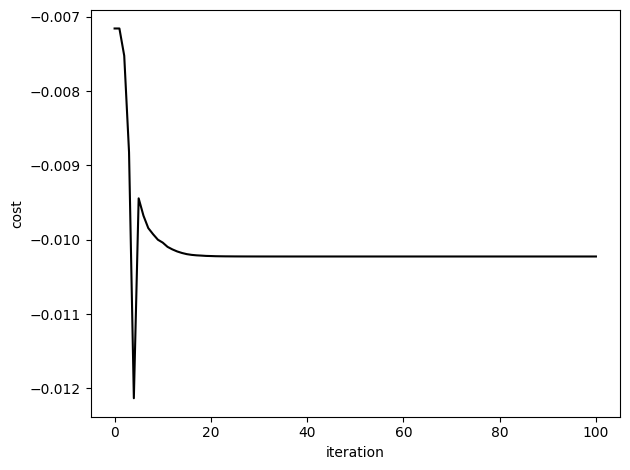

In [97]:
# latexify(fig_width=6.5, fig_height=1.9)

_, ax = plt.subplots(1, 1)
ax.plot([-u for u in test_utils], color='black')
ax.set_ylabel('cost')
ax.set_xlabel('iteration')
# ax.set_ylim([-0.035,-0.0])

# ax.set_yticks([-0.00425, -0.00475, -0.00525])
plt.tight_layout()
# plt.savefig('mark-training.pdf')
# lr 1e-3 10/25 20/0.5

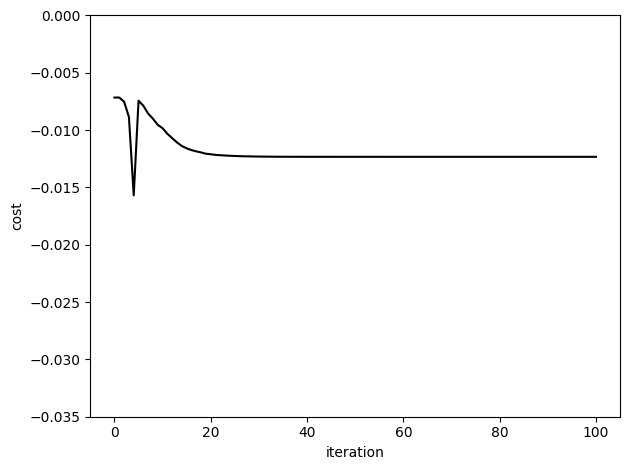

In [91]:
# latexify(fig_width=6.5, fig_height=1.9)

_, ax = plt.subplots(1, 1)
ax.plot([-u for u in test_utils], color='black')
ax.set_ylabel('cost')
ax.set_xlabel('iteration')
ax.set_ylim([-0.035,-0.0])

# ax.set_yticks([-0.00425, -0.00475, -0.00525])
plt.tight_layout()
# plt.savefig('mark-training.pdf')
# lr 1e-3 10/25 20/0.6,

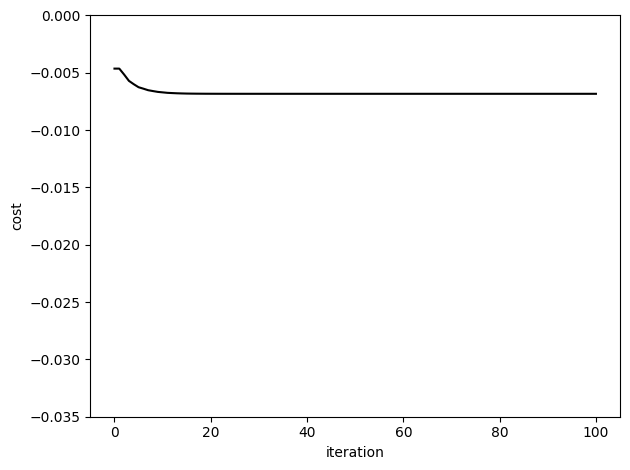

In [67]:
# latexify(fig_width=6.5, fig_height=1.9)

_, ax = plt.subplots(1, 1)
ax.plot([-u for u in test_utils], color='black')
ax.set_ylabel('cost')
ax.set_xlabel('iteration')
ax.set_ylim([-0.035,-0.0])

# ax.set_yticks([-0.00425, -0.00475, -0.00525])
plt.tight_layout()
# plt.savefig('mark-training.pdf')
# lr 1e-3 10/25 20/0.5, square root

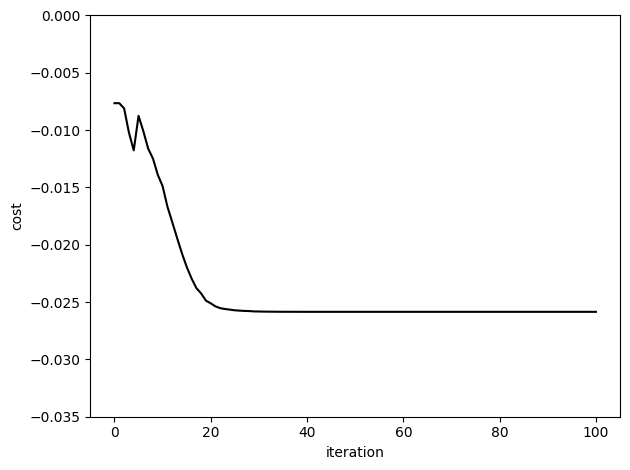

In [61]:
# latexify(fig_width=6.5, fig_height=1.9)

_, ax = plt.subplots(1, 1)
ax.plot([-u for u in test_utils], color='black')
ax.set_ylabel('cost')
ax.set_xlabel('iteration')
ax.set_ylim([-0.035,-0.0])

# ax.set_yticks([-0.00425, -0.00475, -0.00525])
plt.tight_layout()
# plt.savefig('mark-training.pdf')
# lr 1e-3 10/25 20/0.5, gam10

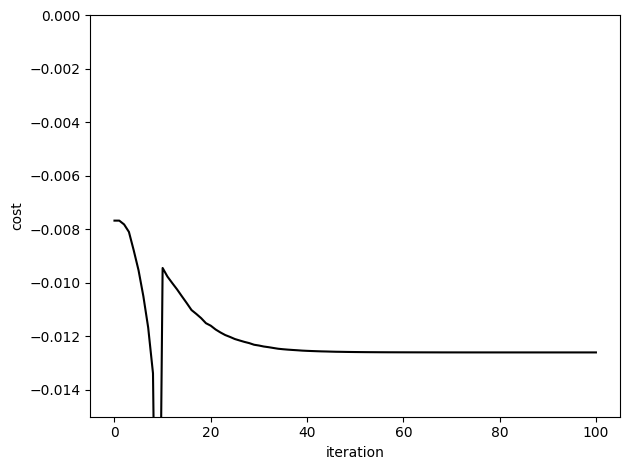

In [29]:
# latexify(fig_width=6.5, fig_height=1.9)

_, ax = plt.subplots(1, 1)
ax.plot([-u for u in test_utils], color='black')
ax.set_ylabel('cost')
ax.set_xlabel('iteration')
ax.set_ylim([-0.015,-0.0])

# ax.set_yticks([-0.00425, -0.00475, -0.00525])
plt.tight_layout()
# plt.savefig('mark-training.pdf')
# lr 1e-3 10/25 20/0.75

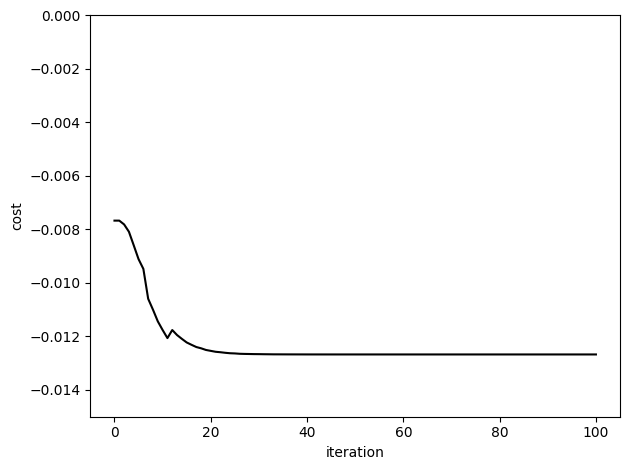

In [20]:
# latexify(fig_width=6.5, fig_height=1.9)

_, ax = plt.subplots(1, 1)
ax.plot([-u for u in test_utils], color='black')
ax.set_ylabel('cost')
ax.set_xlabel('iteration')
ax.set_ylim([-0.015,-0.0])

# ax.set_yticks([-0.00425, -0.00475, -0.00525])
plt.tight_layout()
# plt.savefig('mark-training.pdf')
# lr 5e-4 10/25 20/0.6

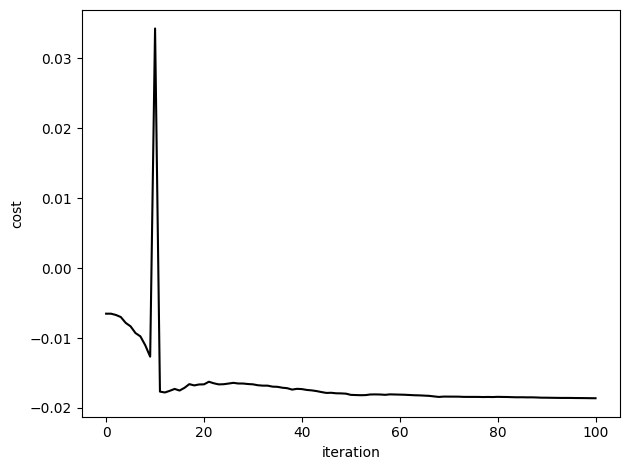

In [ ]:
# latexify(fig_width=6.5, fig_height=1.9)

_, ax = plt.subplots(1, 1)
ax.plot([-u for u in test_utils], color='black')
ax.set_ylabel('cost')
ax.set_xlabel('iteration')
# ax.set_ylim([-0.055,0.015])

# ax.set_yticks([-0.00425, -0.00475, -0.00525])
plt.tight_layout()
# plt.savefig('mark-training.pdf')

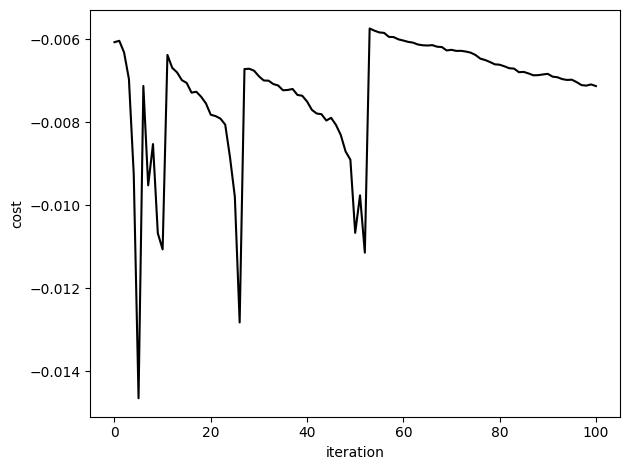

In [22]:
# latexify(fig_width=6.5, fig_height=1.9)

_, ax = plt.subplots(1, 1)
ax.plot([-u for u in test_utils], color='black')
ax.set_ylabel('cost')
ax.set_xlabel('iteration')
# ax.set_ylim([-0.055,0.015])

# ax.set_yticks([-0.00425, -0.00475, -0.00525])
plt.tight_layout()
# plt.savefig('mark-training.pdf')

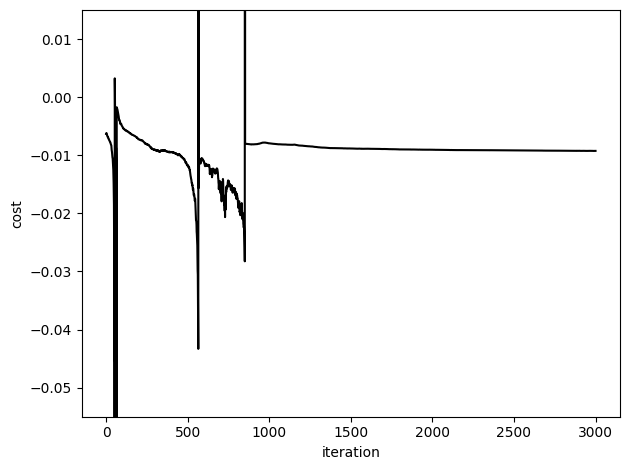

In [32]:
# latexify(fig_width=6.5, fig_height=1.9)

_, ax = plt.subplots(1, 1)
ax.plot([-u for u in test_utils], color='black')
ax.set_ylabel('cost')
ax.set_xlabel('iteration')
ax.set_ylim([-0.055,0.015])

# ax.set_yticks([-0.00425, -0.00475, -0.00525])
plt.tight_layout()
# plt.savefig('mark-training.pdf')

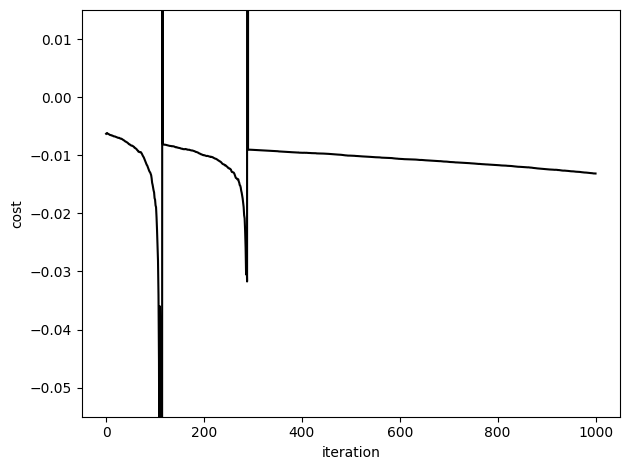

In [27]:
# latexify(fig_width=6.5, fig_height=1.9)

_, ax = plt.subplots(1, 1)
ax.plot([-u for u in test_utils], color='black')
ax.set_ylabel('cost')
ax.set_xlabel('iteration')
ax.set_ylim([-0.055,0.015])

# ax.set_yticks([-0.00425, -0.00475, -0.00525])
plt.tight_layout()
# plt.savefig('mark-training.pdf')

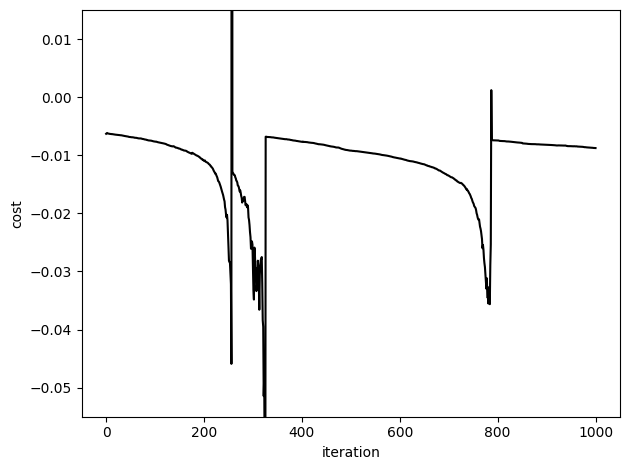

In [21]:
# latexify(fig_width=6.5, fig_height=1.9)

_, ax = plt.subplots(1, 1)
ax.plot([-u for u in test_utils], color='black')
ax.set_ylabel('cost')
ax.set_xlabel('iteration')
ax.set_ylim([-0.055,0.015])

# ax.set_yticks([-0.00425, -0.00475, -0.00525])
plt.tight_layout()
# plt.savefig('mark-training.pdf')

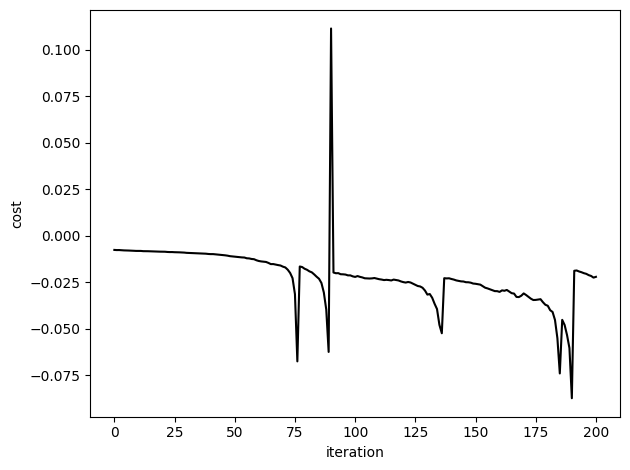

In [55]:
# latexify(fig_width=6.5, fig_height=1.9)
#0.0005
_, ax = plt.subplots(1, 1)
ax.plot([-u for u in test_utils], color='black')
ax.set_ylabel('cost')
ax.set_xlabel('iteration')
# ax.set_yticks([-0.00425, -0.00475, -0.00525])
plt.tight_layout()
# plt.savefig('mark-training.pdf')

In [32]:
print(ETFS)

print(tuned.mu.detach().numpy())

['AGG', 'VTI', 'VNQ', 'XLF', 'XLV', 'XLY', 'XLP', 'XLU', 'XLI', 'XLE', 'IBB', 'ITA']
[-7.53701399  0.94032487 -0.2650584  -1.63693522  3.07062335  6.00289743
  1.59770817  3.25069216  7.13434423 -6.23473929  1.52272826  4.17843292]


In [33]:
print(MU)

[1.0031148  1.00611917 1.00599229 1.00230292 1.00891332 1.00917445
 1.00744866 1.00641088 1.00748575 1.00363468 1.01114635 1.01067012]


In [34]:
tuned.gamma_sqrt.item()**2

12.434301675781512

In [24]:
est_cov = (tuned.cov_sqrt.T @ tuned.cov_sqrt).detach().numpy()
np.median(np.abs((COV - est_cov) / COV))

0.029691643269751593

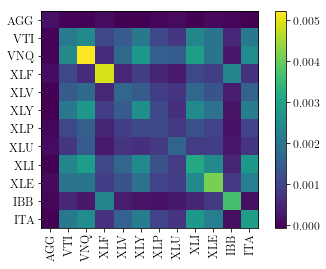

In [25]:
latexify(fig_width=6, fig_height=4)

plt.imshow(est_cov)
plt.colorbar()
plt.xticks(np.arange(N_ASSETS), ETFS, rotation=90)
plt.yticks(np.arange(N_ASSETS), ETFS)
plt.show()